In [99]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import panel as pn 
import copy

import csv
from sklearn.metrics import confusion_matrix
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
from bokeh.io import output_notebook, export_png
from bokeh.plotting import figure,show 
from bokeh.layouts import column, row, grid
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
output_notebook()
pn.extension()

Loading BokehJS ...

In [100]:
def get_config():
    with open("config.yaml", 'r') as stream:
        config = yaml.safe_load(stream)
    return config

In [101]:
def combine_datasets(ccre, euclidean):
    config = get_config()

    ccre_df = pd.read_csv(config[ccre])
  
    euclidean_df = pd.read_csv(config[euclidean])
    
    #combine
    df = pd.concat([euclidean_df, ccre_df], axis=1)
    df = df.loc[:,~df.columns.duplicated()].copy()
    hospitals = df['hospital'].str.split('_') 

    same_centre_bools = [] 
    for hospital in hospitals:
        if hospital[0] == hospital[1]:
            same_centre_bools.append(True)
        else:
            same_centre_bools.append(False)
    df['same_centre'] = same_centre_bools
    return df

In [102]:
df = combine_datasets(ccre="ccre_smote", euclidean="euclidean_smote")
df.loc[df['ccre(X|Y)'].str[0] == '[', "ccre(X|Y)"] = 0
df = df.astype({'ccre(X|Y)':'float'})
df = df.astype({'euclidean_similarity':'float'})
# patients_to_remove = [23, 25, 27,30,32,34,35,36,40,52, 56, 104,110,111,117,120,134,140,148,159,161,162, 171,179,180,181,182,191,192,196,205,211,215,216, 230,233,236,237,238,239,242,243,245, 247,252,253,254,256,258,262,272,275,277,279,284,285,286,287,289,290,291,292,294,295,296,297,298,299,300,301,303]
# df = df[(~df['id_x'].isin(patients_to_remove)) & ~df['id_y'].isin(patients_to_remove)]

In [103]:
df.fillna({'ccre(X|Y)': 1}, inplace=True)
df

,id_x,id_y,hospital,diagnosis,euclidean_distance,euclidean_similarity,cre(x),cre(y),E[cre(X|Y)],ccre(X|Y),same_centre
0,8,273,UMCG_UMCG,HC_HC,23.636084,0.040591,2.433151,1.088477,-2.274083,0.065375,True
1,65,291,UGOSM_UMCG,HC_PD,20.422015,0.046681,1.117492,1.916755,-1.091457,0.023298,False
2,0,1,UMCG_UMCG,HC_HC,24.073100,0.039883,0.939355,2.188344,-0.950970,0.000000,True
3,13,59,UMCG_UGOSM,HC_HC,20.130852,0.047324,1.018866,1.748931,-1.028400,0.000000,False
4,48,97,UGOSM_UGOSM,HC_PD,20.685144,0.046115,1.582176,1.420980,-1.596070,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...
122845,337,317,UGOSM_UGOSM,AD_HC,40.219217,0.024261,4.670432,2.045049,-3.763876,0.194105,True
122846,337,318,UGOSM_UGOSM,AD_HC,34.602340,0.028088,4.670432,2.214702,-2.964809,0.365196,True
122847,337,319,UGOSM_UGOSM,AD_HC,46.388364,0.021102,4.670432,2.490050,-4.432906,0.050857,True
122848,337,320,UGOSM_UGOSM,AD_HC,43.865970,0.022289,4.670432,1.506351,-4.226093,0.095139,True


In [105]:
def compare_scatter_plots(disease1="HC", disease2="HC"):
    
    combine_diseases = f"{disease1}_{disease2}"
    figures = []
    for i in sources_names:

        for j in sources_names:

            combine_centres = f"{i}_{j}"
            dataset = df[(df.hospital == combine_centres) & (df.diagnosis == combine_diseases)]
         

            figure1 = figure(height=400, width=400, title=f"{combine_centres} {combine_diseases}")
            figure1.scatter('ccre(X|Y)', 'euclidean_similarity', source=dataset)
            figure1.xaxis.axis_label = "ccre"
            figure1.yaxis.axis_label = "euclidean similarity"
            figures.append(figure1)
    
    return grid([
        [figures[0], figures[1], figures[2]],
        [figures[3], figures[4], figures[5]],
        [figures[6], figures[7], figures[8]]
    ])
            

sources_names = ["UMCG", "UGOSM", "CUN"]
diagnosis = ["HC", "AD", "PD"]
scatter_plots = pn.interact(compare_scatter_plots, disease1=diagnosis, disease2=diagnosis)
scatter_plots

BokehModel(combine_events=True, render_bundle={'docs_json': {'c31cb3d9-612e-4789-82d3-ec2aa96c1069': {'version…

In [106]:
def cumulative_histogram(diagnosis1 = "PD", diagnosis2 = "PD"):
    
    combine_diseases = f"{diagnosis1}_{diagnosis2}"
    figures = []
    for i in sources_names:

        for j in sources_names:

            combine_centres = f"{i}_{j}"
            data = df[(df.hospital == combine_centres) & (df.diagnosis == combine_diseases)]
            
            ecdf = ECDF(data['ccre(X|Y)'])
            ecdf2 = ECDF(data['euclidean_similarity'])
           
            plot1 = figure(width=400, height=400, title=f"{combine_centres} {combine_diseases}")
            plot1.line(ecdf.x, ecdf.y)
            plot1.line(ecdf2.x, ecdf2.y, color='orange')
          
            figures.append(plot1)
    

    return grid([
        [figures[0], figures[1], figures[2]],
        [figures[3], figures[4], figures[5]],
        [figures[6], figures[7], figures[8]]
    ])
cumulative_plots = pn.interact(cumulative_histogram, diagnosis1=diagnosis, diagnosis2=diagnosis)
cumulative_plots


BokehModel(combine_events=True, render_bundle={'docs_json': {'ceb4b600-6734-4bd2-942b-bd7b2128c8f6': {'version…

In [151]:
sorted_df = df.sort_values(['hospital', 'diagnosis'])
sorted_df

,id_x,id_y,hospital,diagnosis,euclidean_distance,euclidean_similarity,cre(x),cre(y),E[cre(X|Y)],ccre(X|Y),same_centre
34110,149,146,CUN_CUN,HC_HC,21.043230,0.045365,2.143884,2.365266,-1.650297,0.230230,True
34131,149,147,CUN_CUN,HC_HC,17.875354,0.052979,2.143884,1.837461,-1.612424,0.247896,True
34150,149,148,CUN_CUN,HC_HC,25.304043,0.038017,2.143884,2.207705,-1.919637,0.104598,True
34168,149,150,CUN_CUN,HC_HC,19.169892,0.049579,2.143884,2.662615,-1.407027,0.343702,True
34187,149,151,CUN_CUN,HC_HC,19.262487,0.049352,2.143884,2.111014,-1.650191,0.230280,True
...,...,...,...,...,...,...,...,...,...,...,...
120335,302,279,UMCG_UMCG,PD_PD,25.284350,0.038045,1.837965,1.875040,-1.845822,0.000000,True
120347,302,280,UMCG_UMCG,PD_PD,25.803613,0.037308,1.837965,1.915182,-1.850703,0.000000,True
120373,302,281,UMCG_UMCG,PD_PD,4.407179,0.184939,1.837965,1.772173,-0.365049,0.801384,True
120380,302,282,UMCG_UMCG,PD_PD,18.728377,0.050688,1.837965,1.194217,-1.700375,0.074860,True


In [108]:
list_of_id = sorted_df['id_x'].unique()

def adjacency_matrix(metric):
    squared_matrix = []
    temp_values = []
    for i in list_of_id:
 
        

        for j in list_of_id:
            
            if i == j:
                temp_values.append(1)
            else:
                
                temp_values.append(sorted_df[(sorted_df['id_x'] == i) & (sorted_df['id_y'] == j)][metric].values[0])
        if len(temp_values) == len(list_of_id):
            
            squared_matrix.append(temp_values)
            temp_values = []
    return squared_matrix
CCRE_matrix = adjacency_matrix('ccre(X|Y)')
euclidean_matrix = adjacency_matrix('euclidean_similarity')
euclidean_distance_matrix = adjacency_matrix('euclidean_distance')


In [109]:

hospital_diagnosis_full = []

for i in list_of_id:
    
    hospital = df[df['id_x'] == i]['hospital'].values[0].split('_')[0]
    diagnosis = df[df['id_x'] == i]['diagnosis'].values[0].split('_')[0]
    hospital_diagnosis_full.append(f'{hospital}_{diagnosis}')


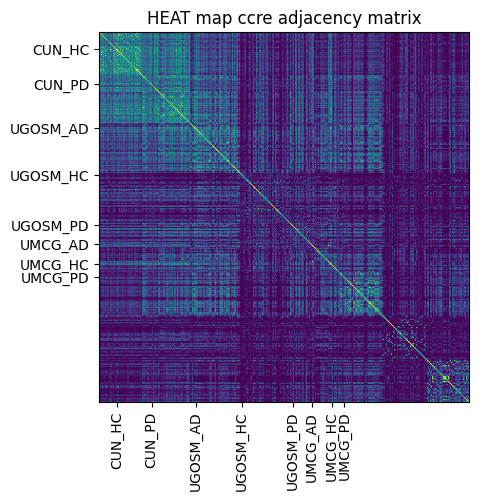

In [110]:
position = [16, 49, 91, 135, 183, 201, 220, 232]
hospital_diagnosis = ['CUN_HC', 'CUN_PD', 'UGOSM_AD', 'UGOSM_HC', 'UGOSM_PD', 'UMCG_AD', 'UMCG_HC', 'UMCG_PD']
plt.xticks(position, hospital_diagnosis, rotation='vertical')
plt.yticks(position, hospital_diagnosis)
plt.title('HEAT map ccre adjacency matrix')
plt.imshow(CCRE_matrix, vmin=0, vmax=1)


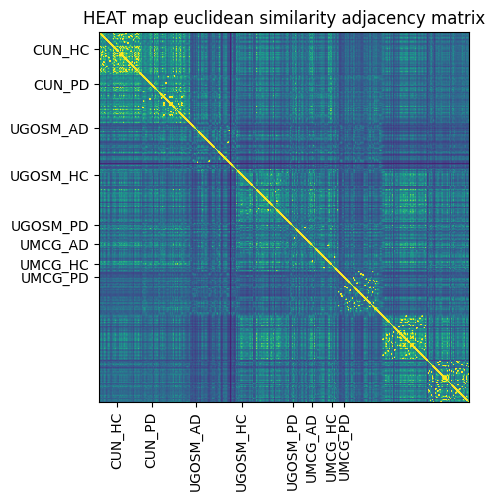

In [111]:

plt.xticks(position, hospital_diagnosis, rotation='vertical')
plt.yticks(position, hospital_diagnosis)
plt.title('HEAT map euclidean similarity adjacency matrix')
plt.imshow(euclidean_matrix, vmin=0, vmax=0.1)

In [112]:
ill_notill = []
one_or_zero = []
for i in hospital_diagnosis_full:
    if i[-2:] == 'AD' or i[-2:] ==  'PD':
        ill_notill.append('ill')
        one_or_zero.append(1)
    else:
        ill_notill.append('notill')
        one_or_zero.append(0)

In [113]:
HC_PD_AD = []
for i in hospital_diagnosis_full:
    if i[-2:] == 'PD':
        HC_PD_AD.append('PD')
    elif i[-2:] == 'AD':
        HC_PD_AD.append('AD')
    elif i[-2:] == 'HC':
        HC_PD_AD.append('HC')


<h1>LDA</h1>

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
iris = datasets.load_iris()


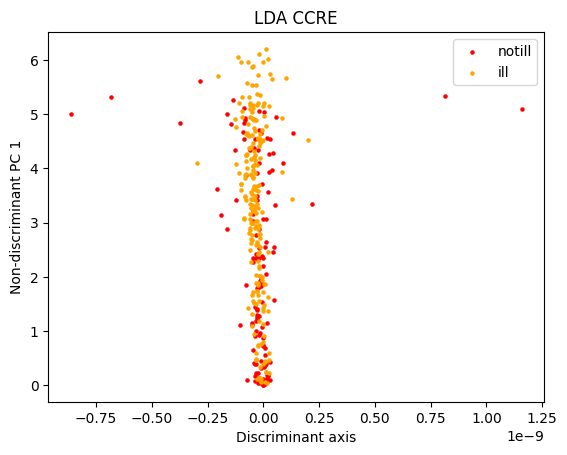

In [115]:
def lda(X, y, title):
     #devide the data
    ill = []
    notill = []
    for index, label in enumerate(y):
        if label == 0:
            notill.append(X[index])
        else:
            ill.append(X[index])
    ill = np.array(ill)
    notill = np.array(notill)
   
    # calculate mean and covariance
    Mill = ill.mean(axis=0)
    Mnotill = notill.mean(axis=0)
    nill = ill.shape[0]
    nnotill = notill.shape[0]
    Cill = np.cov(ill.T)
    Cnotill = np.cov(notill.T)

    #calculate the pooled covariance matrix
    Sp = ((nnotill - 1) * Cnotill + (nill - 1) * Cill) / (nnotill + nill - 2)

    #project data onto the discriminant axis
    a = np.linalg.inv(Sp) @ (Mill - Mnotill) 
    a /= np.sqrt((a ** 2).sum())

    tw = ill @ a 
    tr = notill @ a

    #plot 
    Ew = ill - tw[:, None] * a[None, :]
    Er = notill - tr[:, None] * a[None, :]

    X = np.concatenate((Ew, Er), axis=0)
    S = np.cov(X.T)
    vals, vecs = np.linalg.eig(S)
    order = vals.argsort()[::-1]
    vecs = vecs[:, order]
    vals = vals[order]
    Tw = ill @ vecs
    Tr = notill @ vecs
    plt.title(f"LDA {title}")
    plt.scatter(tr, Tr[:, 0], s=5, c="red", label='notill')
    plt.scatter(tw, Tw[:, 0], s=5, c="orange", label='ill')
    plt.xlabel("Discriminant axis")
    plt.ylabel("Non-discriminant PC 1")
    plt.legend()

lda(CCRE_matrix, one_or_zero, "CCRE")

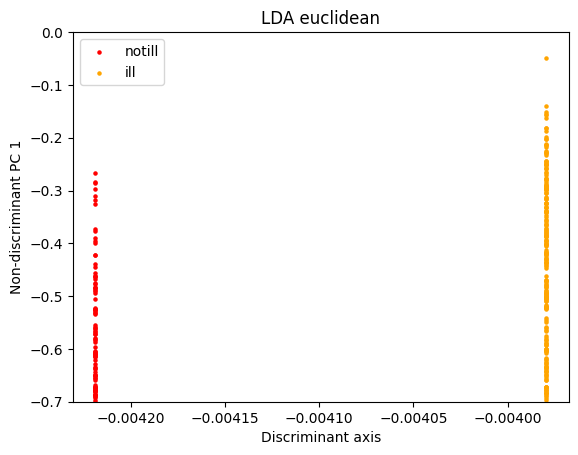

In [116]:

plt.ylim(-0.7,0)
lda(euclidean_matrix, one_or_zero, "euclidean")

PCA

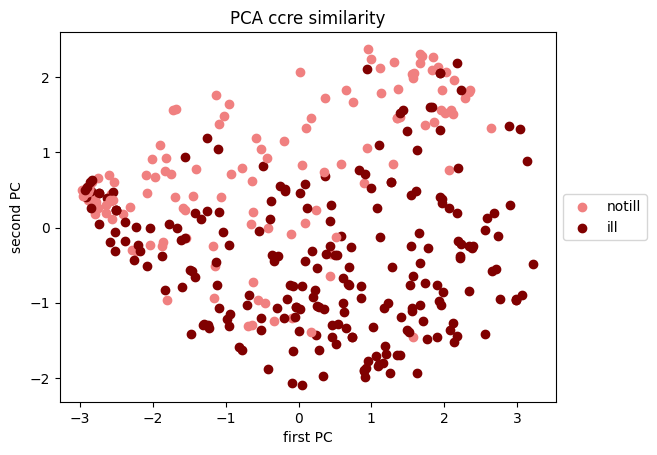

In [117]:
from collections import OrderedDict
X = np.array(CCRE_matrix)
pca = PCA(n_components=232)
pca_fit = pca.fit_transform(X)
data = {'pc1': pca_fit[:, 0], 'pc2':pca_fit[:, 1], 'labels': ill_notill}
test = pd.DataFrame(data).values
colors = {'ill': 'maroon', 'notill': 'lightcoral'}
for i in test:
    plt.scatter(i[0], i[1], color=colors[i[2]],label=i[2])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.title('PCA ccre similarity')
plt.xlabel('first PC')
plt.ylabel('second PC')
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

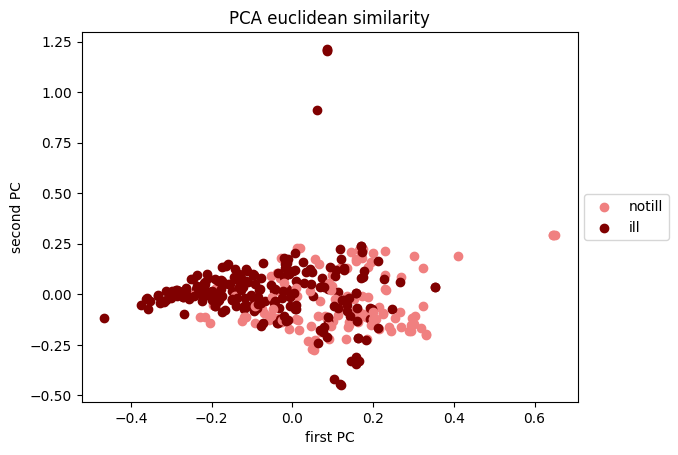

In [118]:
X = np.array(euclidean_matrix)
pca = PCA(n_components=232)
pca_fit = pca.fit_transform(X)
data = {'pc1': pca_fit[:, 0], 'pc2':pca_fit[:, 1], 'labels': ill_notill}
test = pd.DataFrame(data).values
colors = {'ill': 'maroon', 'notill': 'lightcoral',}
for i in test:
    plt.scatter(i[0], i[1], color=colors[i[2]],label=i[2])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.title('PCA euclidean similarity')
plt.xlabel('first PC')
plt.ylabel('second PC')

plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

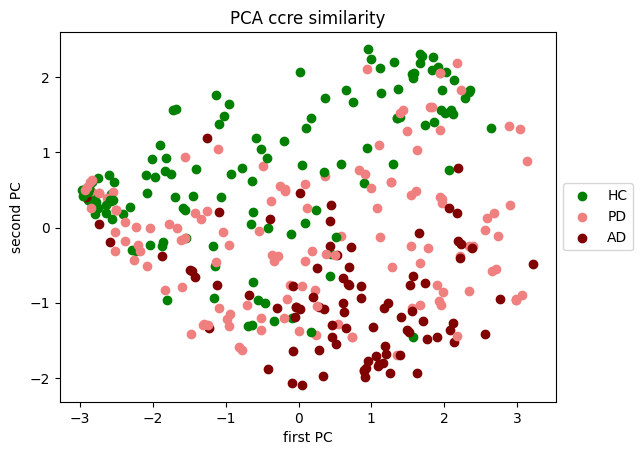

In [119]:
from collections import OrderedDict
X = np.array(CCRE_matrix)
pca = PCA(n_components=232)
pca_fit = pca.fit_transform(X)
data = {'pc1': pca_fit[:, 0], 'pc2':pca_fit[:, 1], 'labels': HC_PD_AD}
test = pd.DataFrame(data).values
colors = {'AD': 'maroon', 'PD': 'lightcoral', 'HC': 'green'}
for i in test:
    plt.scatter(i[0], i[1], color=colors[i[2]],label=i[2])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.title('PCA ccre similarity')
plt.xlabel('first PC')
plt.ylabel('second PC')
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

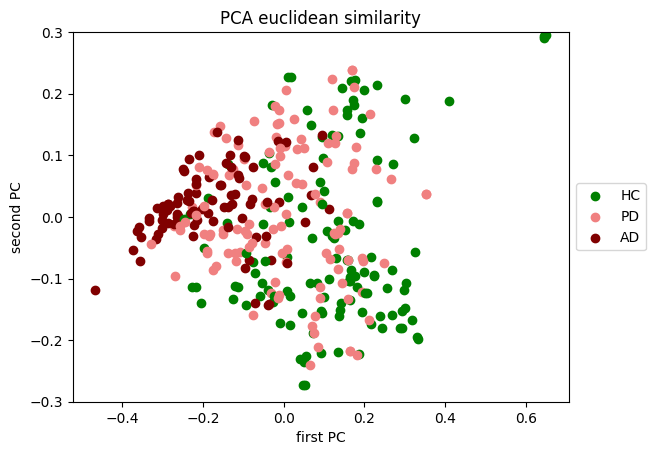

In [120]:
X = np.array(euclidean_matrix)
pca = PCA(n_components=232)
pca_fit = pca.fit_transform(X)
data = {'pc1': pca_fit[:, 0], 'pc2':pca_fit[:, 1], 'labels': HC_PD_AD}
test = pd.DataFrame(data).values
colors = {'AD': 'maroon', 'PD': 'lightcoral', 'HC': 'green'}
for i in test:
    plt.scatter(i[0], i[1], color=colors[i[2]],label=i[2])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.title('PCA euclidean similarity')
plt.xlabel('first PC')
plt.ylabel('second PC')
plt.ylim(-0.3, 0.3)
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

In [121]:
def compare_metrics(hospital, first_diagnosis, second_diagnosis):

    first = df[(df['hospital'] == hospital) & (df['diagnosis'] == f"{first_diagnosis}_{first_diagnosis}")]
    second = df[(df['hospital'] == hospital) & (df['diagnosis'] == f"{second_diagnosis}_{second_diagnosis}")]

    third = df[(df['hospital'] == hospital) & (df['diagnosis'] == f"{first_diagnosis}_{second_diagnosis}")]
    fourth = df[(df['hospital'] == hospital) & (df['diagnosis'] == f"{second_diagnosis}_{first_diagnosis}")]
    
    #euclidean distance
    euclidean_first = first['euclidean_distance'].median() / (pd.concat([third['euclidean_distance'], fourth['euclidean_distance']])).median()
    euclidean_second = second['euclidean_distance'].median() / (pd.concat([third['euclidean_distance'], fourth['euclidean_distance']])).median()
    
    #ccre
    ccre_first = (1- first['ccre(X|Y)']).median() / (pd.concat([1 - third['ccre(X|Y)'], 1 - fourth['ccre(X|Y)']])).median()
    ccre_second = (1-second['ccre(X|Y)']).median() / (pd.concat([1 - third['ccre(X|Y)'], 1 - fourth['ccre(X|Y)']])).median()
    
    header = ['formula', 'hospital','first_diagnosis', 'second_diagnosis' 'ccre_average', 'euclidean distance average', 'ccre<euclidean']
    data_first_formula = [
        f'mean({first_diagnosis})/ mean(between {first_diagnosis} and {second_diagnosis})',
        hospital,
        first_diagnosis,
        second_diagnosis,
        ccre_first,
        euclidean_first,
        ccre_first<euclidean_first
    ]
    data_second_formula = [
        f'mean({second_diagnosis})/ mean(between {first_diagnosis} and {second_diagnosis})',
        hospital,
        first_diagnosis,
        second_diagnosis,
        ccre_second,
        euclidean_second,
        f'{ccre_second<euclidean_second}'
    ]
    file_created = False
    with open(f"compare_euclidean_ccre_distance.csv", "a", newline="") as file:
        writer = csv.writer(file)
        
        if file_created:
            
            writer.writerow(header)
            writer.writerow(data_first_formula)
            writer.writerow(data_second_formula)
            file_created = True
        else:
            writer.writerow(data_first_formula)
            writer.writerow(data_second_formula)
    print(f'formula 1 mean({first_diagnosis})/ mean(between {first_diagnosis} and {second_diagnosis}) , ccre average = {ccre_first}, euclidean distance average = {euclidean_first}, ccre < euclidean similarity {ccre_first<euclidean_first}')
    print(f'formula 2 mean({second_diagnosis})/ mean(between {first_diagnosis} and {second_diagnosis}) , ccre average = {ccre_second}, euclidean distance average = {euclidean_second}, ccre < euclidean similarity {ccre_second<euclidean_second}\n')


In [122]:
hospitals = ['UMCG_UMCG', 'UMCG_UGOSM', 'UMCG_CUN', 'UGOSM_UMCG', 'UGOSM_UGOSM',
       'UGOSM_CUN', 'CUN_UMCG', 'CUN_UGOSM', 'CUN_CUN']
for hospital in hospitals:
    print(hospital)
    compare_metrics(hospital, 'HC', 'PD')
    if "CUN" not in hospital:
       compare_metrics(hospital, 'HC', 'AD')
       compare_metrics(hospital, 'AD', 'PD')


UMCG_UMCG
formula 1 mean(HC)/ mean(between HC and PD) , ccre average = 1.013525723048351, euclidean distance average = 0.8039065609613686, ccre < euclidean similarity False
formula 2 mean(PD)/ mean(between HC and PD) , ccre average = 0.8922797039926401, euclidean distance average = 0.9530255218596979, ccre < euclidean similarity True

formula 1 mean(HC)/ mean(between HC and AD) , ccre average = 1.0131712867134897, euclidean distance average = 0.569976146453483, ccre < euclidean similarity False
formula 2 mean(AD)/ mean(between HC and AD) , ccre average = 0.7354100998366686, euclidean distance average = 0.8529503209637439, ccre < euclidean similarity True

formula 1 mean(AD)/ mean(between AD and PD) , ccre average = 0.8204344179817337, euclidean distance average = 0.9375884227383333, ccre < euclidean similarity True
formula 2 mean(PD)/ mean(between AD and PD) , ccre average = 0.9950923638984656, euclidean distance average = 0.7427525268161163, ccre < euclidean similarity False

UMCG_UGO

In [123]:
config = get_config()

compare_euclidean_ccre_df = pd.read_csv(config['compare_euclidean_ccre'])
compare_within = compare_euclidean_ccre_df[compare_euclidean_ccre_df['hospital'].isin(['UMCG_UMCG', 'CUN_CUN', 'UGOSM_UGOSM'])]
compare_outside = compare_euclidean_ccre_df[~compare_euclidean_ccre_df['hospital'].isin(['UMCG_UMCG', 'CUN_CUN', 'UGOSM_UGOSM'])]
compare_euclidean_ccre_df

,formula,hospital,first_diagnosis,second_diagnosis,ccre_average,euclidean distance average,ccre<euclidean
0,mean(HC)/ mean(between HC and PD),UMCG_UMCG,HC,PD,0.501061,0.752090,True
1,mean(PD)/ mean(between HC and PD),UMCG_UMCG,HC,PD,6.460792,0.969881,False
2,mean(HC)/ mean(between HC and AD),UMCG_UMCG,HC,AD,0.998156,0.608722,False
3,mean(AD)/ mean(between HC and AD),UMCG_UMCG,HC,AD,25.493221,0.927589,False
4,mean(AD)/ mean(between AD and PD),UMCG_UMCG,AD,PD,1.676293,1.016331,False
5,mean(PD)/ mean(between AD and PD),UMCG_UMCG,AD,PD,0.846288,0.860096,True
6,mean(HC)/ mean(between HC and PD),UMCG_UGOSM,HC,PD,0.698864,0.822434,True
7,mean(PD)/ mean(between HC and PD),UMCG_UGOSM,HC,PD,2.903729,1.039310,False
8,mean(HC)/ mean(between HC and AD),UMCG_UGOSM,HC,AD,0.571922,0.642064,True
9,mean(AD)/ mean(between HC and AD),UMCG_UGOSM,HC,AD,7.556021,0.931350,False


<h1>HC == HC</h1>

In [124]:
from collections import Counter
def plot_pie(values, title):
 
    counter = Counter(values)
    values = [counter[0]/values.count()* 100, counter[1]/values.count()*100]
    labels = ['False', 'True']
    plt.title(title)
    plt.pie(values, labels=labels)
    plt.legend()


,formula,hospital,first_diagnosis,second_diagnosis,ccre_average,euclidean distance average,ccre<euclidean
0,mean(HC)/ mean(between HC and PD),UMCG_UMCG,HC,PD,0.501061,0.752090,True
2,mean(HC)/ mean(between HC and AD),UMCG_UMCG,HC,AD,0.998156,0.608722,False
20,mean(HC)/ mean(between HC and PD),UGOSM_UGOSM,HC,PD,1.117098,0.839832,False
22,mean(HC)/ mean(between HC and AD),UGOSM_UGOSM,HC,AD,0.862189,0.630641,False
32,mean(HC)/ mean(between HC and PD),CUN_CUN,HC,PD,1.249350,0.881680,False


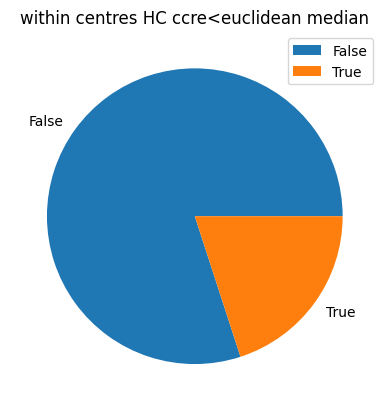

In [125]:
values = compare_within[compare_within['formula'].str[5:7] == 'HC']['ccre<euclidean'].astype(int)

plot_pie(values, 'within centres HC ccre<euclidean median')
compare_within[compare_within['formula'].str[5:7] == 'HC']


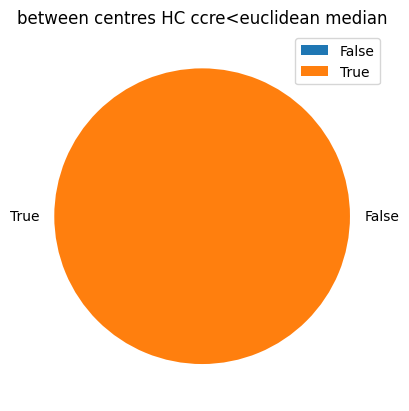

In [126]:
values = compare_outside[compare_outside['formula'].str[5:7] == 'HC']['ccre<euclidean'].astype(int)
plot_pie(values, 'between centres HC ccre<euclidean median')

<h1>HC != PD or AD</h1>

In [127]:
compare_euclidean_ccre_df[(compare_euclidean_ccre_df['formula'].str[5:7] == 'HC') &(compare_euclidean_ccre_df['second_diagnosis'].isin(['PD', 'AD']))]

,formula,hospital,first_diagnosis,second_diagnosis,ccre_average,euclidean distance average,ccre<euclidean
0,mean(HC)/ mean(between HC and PD),UMCG_UMCG,HC,PD,0.501061,0.752090,True
2,mean(HC)/ mean(between HC and AD),UMCG_UMCG,HC,AD,0.998156,0.608722,False
6,mean(HC)/ mean(between HC and PD),UMCG_UGOSM,HC,PD,0.698864,0.822434,True
8,mean(HC)/ mean(between HC and AD),UMCG_UGOSM,HC,AD,0.571922,0.642064,True
12,mean(HC)/ mean(between HC and PD),UMCG_CUN,HC,PD,0.769283,0.906771,True
14,mean(HC)/ mean(between HC and PD),UGOSM_UMCG,HC,PD,0.697106,0.822434,True
16,mean(HC)/ mean(between HC and AD),UGOSM_UMCG,HC,AD,0.571922,0.642064,True
20,mean(HC)/ mean(between HC and PD),UGOSM_UGOSM,HC,PD,1.117098,0.839832,False
22,mean(HC)/ mean(between HC and AD),UGOSM_UGOSM,HC,AD,0.862189,0.630641,False
26,mean(HC)/ mean(between HC and PD),UGOSM_CUN,HC,PD,0.719609,0.947423,True


<h1>AD or PD != AD or PD</h1>

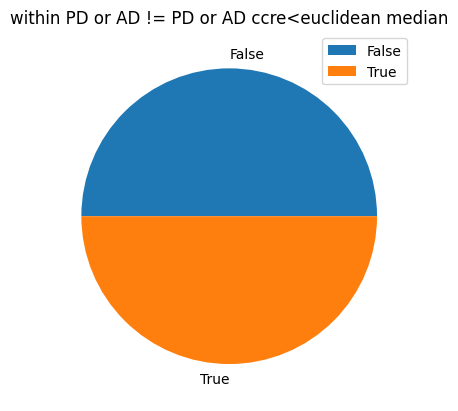

In [128]:
values = compare_within[compare_within['first_diagnosis'] == 'AD']['ccre<euclidean'].astype(int)
plot_pie(values, 'within PD or AD != PD or AD ccre<euclidean median')

,formula,hospital,first_diagnosis,second_diagnosis,ccre_average,euclidean distance average,ccre<euclidean
10,mean(AD)/ mean(between AD and PD),UMCG_UGOSM,AD,PD,1.73646,1.024056,False
11,mean(PD)/ mean(between AD and PD),UMCG_UGOSM,AD,PD,0.54610,0.892141,True
18,mean(AD)/ mean(between AD and PD),UGOSM_UMCG,AD,PD,1.73646,1.024056,False
19,mean(PD)/ mean(between AD and PD),UGOSM_UMCG,AD,PD,0.55071,0.892141,True


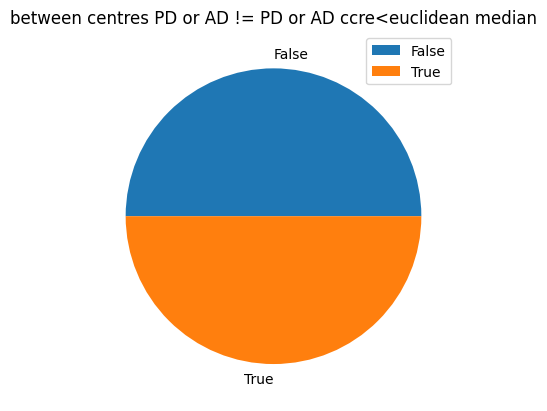

In [129]:
values = compare_outside[compare_outside['first_diagnosis'] == 'AD']['ccre<euclidean'].astype(int)
plot_pie(values, 'between centres PD or AD != PD or AD ccre<euclidean median')
compare_outside[compare_outside['first_diagnosis'] == 'AD']

<h1>PD > AD</h1>

In [130]:
compare_euclidean_ccre_df[compare_euclidean_ccre_df['formula'].str[5:7].isin(['PD', 'AD'])]

,formula,hospital,first_diagnosis,second_diagnosis,ccre_average,euclidean distance average,ccre<euclidean
1,mean(PD)/ mean(between HC and PD),UMCG_UMCG,HC,PD,6.460792,0.969881,False
3,mean(AD)/ mean(between HC and AD),UMCG_UMCG,HC,AD,25.493221,0.927589,False
4,mean(AD)/ mean(between AD and PD),UMCG_UMCG,AD,PD,1.676293,1.016331,False
5,mean(PD)/ mean(between AD and PD),UMCG_UMCG,AD,PD,0.846288,0.860096,True
7,mean(PD)/ mean(between HC and PD),UMCG_UGOSM,HC,PD,2.903729,1.039310,False
9,mean(AD)/ mean(between HC and AD),UMCG_UGOSM,HC,AD,7.556021,0.931350,False
10,mean(AD)/ mean(between AD and PD),UMCG_UGOSM,AD,PD,1.736460,1.024056,False
11,mean(PD)/ mean(between AD and PD),UMCG_UGOSM,AD,PD,0.546100,0.892141,True
13,mean(PD)/ mean(between HC and PD),UMCG_CUN,HC,PD,3.245792,1.009144,False
15,mean(PD)/ mean(between HC and PD),UGOSM_UMCG,HC,PD,2.920879,1.039310,False


<h1>kNN</h1>
Because we have all the distances we dont need to implement the actual model but instead can use the adjacency matrix

In [131]:
CCRE_matrix

list_of_labels = []
for i in list_of_id:
    hospital = sorted_df[sorted_df['id_x'] == i].iloc[0]['hospital'].split('_')[0]
    diagnosis = sorted_df[sorted_df['id_x'] == i].iloc[0]['diagnosis'].split('_')[0]
    list_of_labels.append(f'{hospital}_{diagnosis}')

In [132]:
import random
testlist = [
    [round((position[0] - 0) /100*20), position[0], 0],
    [round((position[1] - position[0]) /100*20),position[1], position[0]],
    [round((position[2] - position[1]) /100*20),position[2], position[1]],
    [round((position[3] - position[2]) /100*20),position[3], position[2]],
    [round((position[4] - position[3]) /100*20),position[4], position[3]],
    [round((position[5] - position[4]) /100*20),position[5], position[4]],
    [round((position[6] - position[5]) /100*20),position[6], position[5]],
    [round((position[7] - position[6]) /100*20),position[7], position[6]],
    ]
def randomints(amount, position1, position2):
    return random.sample(range(position1, position2), amount)
testset =[]
for i in testlist:
    for j in randomints(i[0], i[2], i[1]):
        testset.append(j)


In [133]:
matrices = copy.deepcopy(CCRE_matrix)
for i in matrices:
    for j in testset[::-1]:

        i.pop(j)

def knn(k, x, y):
    correct_predicted = []
    for index,matrix in enumerate(matrices):
        if index in testset:
            
            actual_value = y[0]
            predicted_values = []
            for K in range(1, k):
                number = [i for i in range(len(CCRE_matrix[index])) if CCRE_matrix[index][i] == (sorted(matrix, reverse=True)[K])][0]
            
                predicted_values.append(list_of_labels[number].split('_')[1])
            counter = Counter(predicted_values)
            predicted_value = max(counter, key=counter.get)
            correct_predicted.append([list_of_labels[number] , actual_value, predicted_value == actual_value.split('_')[1]])
    
    return correct_predicted

for i in range(2,20):
    test = knn(i, copy.deepcopy(CCRE_matrix), list_of_labels)    
    true = 0
    false = 0
    for j in test:
        if j[2]:
            true +=1
        else:
            false +=1

    print(f'neighbours = {i-1}, incorrect predicted = {false}, correct predicted = {true}')

neighbours = 1, incorrect predicted = 32, correct predicted = 15
neighbours = 2, incorrect predicted = 32, correct predicted = 15
neighbours = 3, incorrect predicted = 32, correct predicted = 15
neighbours = 4, incorrect predicted = 33, correct predicted = 14
neighbours = 5, incorrect predicted = 30, correct predicted = 17
neighbours = 6, incorrect predicted = 30, correct predicted = 17
neighbours = 7, incorrect predicted = 31, correct predicted = 16
neighbours = 8, incorrect predicted = 30, correct predicted = 17
neighbours = 9, incorrect predicted = 28, correct predicted = 19
neighbours = 10, incorrect predicted = 30, correct predicted = 17
neighbours = 11, incorrect predicted = 29, correct predicted = 18
neighbours = 12, incorrect predicted = 28, correct predicted = 19
neighbours = 13, incorrect predicted = 29, correct predicted = 18
neighbours = 14, incorrect predicted = 29, correct predicted = 18
neighbours = 15, incorrect predicted = 30, correct predicted = 17
neighbours = 16, in

In [134]:
def rename_labels(labels):
    new_labels = []
    for label in labels:
        if label[-2:] == 'AD' or label[-2:] == 'PD':
            
            new_labels.append('ill')
        else:
           
            new_labels.append('healthy')
    return new_labels

def split_data(X, y):
    X = copy.deepcopy(X)
    test_X = []
    test_y = []
    for i in sorted(testset):
      
        for j in testset[::-1]:
            
            X[i].pop(j)
        test_X.append(X[i])
        test_y.append(y[i])
    return test_X, test_y
def knn(k, X, y, original_matrix, reversed=True):
    # loop throught each testrow
    correct_predicted = []
    for index, number in enumerate(sorted(testset)):
        
        actual_value = y[index]
       
        predicted_values = []
        # loop through k neighbours
        for K in range(0,k):
          
            numbers = [i for i in range(len(original_matrix[number])) if original_matrix[number][i] == (sorted(X[index], reverse=reversed)[K])][0]
            label = list_of_labels[numbers].split('_')[1]
              
            if label == 'AD' or label == 'PD':
            
                predicted_values.append('ill')
            else:
                predicted_values.append('healthy')
        counter = Counter(predicted_values)
      
        predicted_value = max(counter, key=counter.get)
        correct_predicted.append([predicted_value, actual_value, predicted_value == actual_value])
    return correct_predicted
        

for i in range(1,20):
    labels = rename_labels(list_of_labels)
    test_X, test_y = split_data(CCRE_matrix, labels)
    test_euclidean = knn(i, test_X, test_y, CCRE_matrix)
    true = 0
    false = 0
    for j in test_euclidean:
        if j[2]:
            true +=1
        else:
            false +=1

    print(f'neighbours = {i}, incorrect predicted = {false}, correct predicted = {true}')


neighbours = 1, incorrect predicted = 7, correct predicted = 40
neighbours = 2, incorrect predicted = 7, correct predicted = 40
neighbours = 3, incorrect predicted = 9, correct predicted = 38
neighbours = 4, incorrect predicted = 9, correct predicted = 38
neighbours = 5, incorrect predicted = 10, correct predicted = 37
neighbours = 6, incorrect predicted = 11, correct predicted = 36
neighbours = 7, incorrect predicted = 11, correct predicted = 36
neighbours = 8, incorrect predicted = 11, correct predicted = 36
neighbours = 9, incorrect predicted = 11, correct predicted = 36
neighbours = 10, incorrect predicted = 11, correct predicted = 36
neighbours = 11, incorrect predicted = 11, correct predicted = 36
neighbours = 12, incorrect predicted = 8, correct predicted = 39
neighbours = 13, incorrect predicted = 8, correct predicted = 39
neighbours = 14, incorrect predicted = 9, correct predicted = 38
neighbours = 15, incorrect predicted = 7, correct predicted = 40
neighbours = 16, incorrect 

In [135]:
for i in range(1,20):
    labels = rename_labels(list_of_labels)
    test_X, test_y = split_data(euclidean_matrix, labels)
    test_euclidean = knn(i, test_X, test_y, euclidean_matrix)
    true = 0
    false = 0
    for j in test_euclidean:
        if j[2]:
            true +=1
        else:
            false +=1

    print(f'neighbours = {i}, incorrect predicted = {false}, correct predicted = {true}')

neighbours = 1, incorrect predicted = 4, correct predicted = 43
neighbours = 2, incorrect predicted = 4, correct predicted = 43
neighbours = 3, incorrect predicted = 8, correct predicted = 39
neighbours = 4, incorrect predicted = 8, correct predicted = 39
neighbours = 5, incorrect predicted = 10, correct predicted = 37
neighbours = 6, incorrect predicted = 9, correct predicted = 38
neighbours = 7, incorrect predicted = 9, correct predicted = 38
neighbours = 8, incorrect predicted = 7, correct predicted = 40
neighbours = 9, incorrect predicted = 8, correct predicted = 39
neighbours = 10, incorrect predicted = 8, correct predicted = 39
neighbours = 11, incorrect predicted = 8, correct predicted = 39
neighbours = 12, incorrect predicted = 7, correct predicted = 40
neighbours = 13, incorrect predicted = 7, correct predicted = 40
neighbours = 14, incorrect predicted = 6, correct predicted = 41
neighbours = 15, incorrect predicted = 9, correct predicted = 38


KeyboardInterrupt: 

In [ ]:
for i in range(1,20):
    labels = rename_labels(list_of_labels)
    test_X, test_y = split_data(euclidean_distance_matrix, labels)
    test_euclidean = knn(i, test_X, test_y, euclidean_distance_matrix, reversed=False)
    true = 0
    false = 0
    for j in test_euclidean:
        if j[2]:
            true +=1
        else:
            false +=1

    print(f'neighbours = {i}, incorrect predicted = {false}, correct predicted = {true}')

neighbours = 1, incorrect predicted = 3, correct predicted = 44
neighbours = 2, incorrect predicted = 3, correct predicted = 44
neighbours = 3, incorrect predicted = 6, correct predicted = 41
neighbours = 4, incorrect predicted = 6, correct predicted = 41
neighbours = 5, incorrect predicted = 7, correct predicted = 40
neighbours = 6, incorrect predicted = 6, correct predicted = 41
neighbours = 7, incorrect predicted = 8, correct predicted = 39
neighbours = 8, incorrect predicted = 6, correct predicted = 41
neighbours = 9, incorrect predicted = 8, correct predicted = 39
neighbours = 10, incorrect predicted = 6, correct predicted = 41
neighbours = 11, incorrect predicted = 8, correct predicted = 39
neighbours = 12, incorrect predicted = 5, correct predicted = 42
neighbours = 13, incorrect predicted = 10, correct predicted = 37
neighbours = 14, incorrect predicted = 8, correct predicted = 39
neighbours = 15, incorrect predicted = 9, correct predicted = 38
neighbours = 16, incorrect predic

<h1>undersampling for knn</h1>

In [ ]:
dict_labels_count = Counter(list_of_labels)
amount = min(dict_labels_count.items(), key=lambda x: x[1])[1]
undersampled_data= []
for index, label in enumerate(list_of_labels):
    if label not in np.array(undersampled_data):
        undersampled_data.append([label, index])
    elif Counter(np.array(undersampled_data)[:, 0])[label] != amount:
        undersampled_data.append([label, index])
print(undersampled_data)
print(dict_labels_count)

[['CUN_HC', 0], ['CUN_HC', 1], ['CUN_HC', 2], ['CUN_HC', 3], ['CUN_HC', 4], ['CUN_HC', 5], ['CUN_HC', 6], ['CUN_HC', 7], ['CUN_HC', 8], ['CUN_HC', 9], ['CUN_HC', 10], ['CUN_HC', 11], ['CUN_HC', 12], ['CUN_HC', 13], ['CUN_HC', 14], ['CUN_HC', 15], ['CUN_HC', 16], ['CUN_HC', 17], ['CUN_HC', 18], ['CUN_HC', 19], ['CUN_HC', 20], ['CUN_HC', 21], ['CUN_HC', 22], ['CUN_HC', 23], ['CUN_HC', 24], ['CUN_HC', 25], ['CUN_HC', 26], ['CUN_HC', 27], ['CUN_HC', 28], ['CUN_HC', 29], ['CUN_HC', 30], ['CUN_HC', 31], ['CUN_HC', 32], ['CUN_HC', 33], ['CUN_HC', 34], ['CUN_HC', 35], ['CUN_HC', 36], ['CUN_HC', 37], ['CUN_HC', 38], ['CUN_HC', 39], ['CUN_PD', 41], ['CUN_PD', 42], ['CUN_PD', 43], ['CUN_PD', 44], ['CUN_PD', 45], ['CUN_PD', 46], ['CUN_PD', 47], ['CUN_PD', 48], ['CUN_PD', 49], ['CUN_PD', 50], ['CUN_PD', 51], ['CUN_PD', 52], ['CUN_PD', 53], ['CUN_PD', 54], ['CUN_PD', 55], ['CUN_PD', 56], ['CUN_PD', 57], ['CUN_PD', 58], ['CUN_PD', 59], ['CUN_PD', 60], ['CUN_PD', 61], ['CUN_PD', 62], ['CUN_PD', 63], [

In [ ]:
undersampled_CCRE_matrix = [[CCRE_matrix[int(i)][int(j)] for j in np.array(undersampled_data)[:, 1]] for i in np.array(undersampled_data)[:, 1]]
undersampled_euclidean_matrix = [[euclidean_matrix[int(i)][int(j)] for j in np.array(undersampled_data)[:, 1]] for i in np.array(undersampled_data)[:, 1]]
np.array(undersampled_CCRE_matrix).shape 
print(np.array(CCRE_matrix).shape)

(351, 351)


In [136]:
# splitting the data
def split_data(undersampled_data, percentage_test_set = 25):
    test_set = []
    print(undersampled_data)
    for i in Counter(np.array(undersampled_data)[:,0]).items():
        amount  = int(i[1]/100*percentage_test_set)
        randomselected = random.sample([j for j in undersampled_data if j[0] == i[0]], amount)
        for sample in randomselected:
            test_set.append(sample)
    training_set = [i for i in undersampled_data if (str(i[1]) not in np.array(test_set)[:, 1])]
    return test_set, training_set   
   

test_set, training_set = split_data(undersampled_data)
print(test_set)
CCRE_training = [[CCRE_matrix[int(i)][int(j)] for j in np.array(training_set)[:, 1]] for i in np.array(training_set)[:, 1]]
CCRE_test = [[CCRE_matrix[int(i)][int(j)] for j in np.array(training_set)[:, 1]] for i in np.array(test_set)[:, 1]]
euclidean_training = [[euclidean_matrix[int(i)][int(j)] for j in np.array(training_set)[:, 1]] for i in np.array(training_set)[:, 1]]
euclidean_test = [[euclidean_matrix[int(i)][int(j)] for j in np.array(training_set)[:, 1]] for i in np.array(test_set)[:, 1]]

def knn_3_classes(k, test_X, test_y, original_matrix):
    correct_predicted = []
    for index, row in enumerate(np.array(test_y)[:, 1]):
        
        actual = test_y[index]
        predicted = []
        for K in range(k):
            prediction_number=[i for i in range(len(original_matrix[int(row)])) if original_matrix[int(row)][i] == sorted(test_X[index], reverse=True)[K]][0]
            label = [i for i in training_set if i[1] == prediction_number][0][0].split('_')[1]
            predicted.append(label)
        
        
        counter = Counter(predicted)
        predicted_value = max(counter, key=counter.get)
        actual = actual[0].split('_')[1]
        
        # predicted_value = max(counter, key=counter.get)
        correct_predicted.append([predicted_value, actual, predicted_value == actual])
    return correct_predicted
print('ccre')          
for i in range(1, 9):
    test_ccre = knn_3_classes(i, CCRE_test, test_set, CCRE_matrix)
    predicted = np.array(test_ccre)[:, 0]
    actual = np.array(test_ccre)[:, 1]
    print(confusion_matrix(actual, predicted, labels=["HC", "PD", "AD"]))
    true = 0
    false = 0
    for j in test_ccre:
        if j[2]:
            true +=1
        else:
            false +=1

    print(f'neighbours = {i}, incorrect predicted = {false}, correct predicted = {true}')
print('euclidean')
for i in range(1, 9):
    test_ccre = knn_3_classes(i, euclidean_test, test_set, euclidean_matrix)
    predicted = np.array(test_ccre)[:, 0]
    actual = np.array(test_ccre)[:, 1]
    print(confusion_matrix(actual, predicted, labels=["HC", "PD", "AD"]))
    true = 0
    false = 0
    for j in test_ccre:
        if j[2]:
            true +=1
        else:
            false +=1

    print(f'neighbours = {i}, incorrect predicted = {false}, correct predicted = {true}')

[['CUN_HC', 0], ['CUN_HC', 1], ['CUN_HC', 2], ['CUN_HC', 3], ['CUN_HC', 4], ['CUN_HC', 5], ['CUN_HC', 6], ['CUN_HC', 7], ['CUN_HC', 8], ['CUN_HC', 9], ['CUN_HC', 10], ['CUN_HC', 11], ['CUN_HC', 12], ['CUN_HC', 13], ['CUN_HC', 14], ['CUN_HC', 15], ['CUN_HC', 16], ['CUN_HC', 17], ['CUN_HC', 18], ['CUN_HC', 19], ['CUN_HC', 20], ['CUN_HC', 21], ['CUN_HC', 22], ['CUN_HC', 23], ['CUN_HC', 24], ['CUN_HC', 25], ['CUN_HC', 26], ['CUN_HC', 27], ['CUN_HC', 28], ['CUN_HC', 29], ['CUN_HC', 30], ['CUN_HC', 31], ['CUN_HC', 32], ['CUN_HC', 33], ['CUN_HC', 34], ['CUN_HC', 35], ['CUN_HC', 36], ['CUN_HC', 37], ['CUN_HC', 38], ['CUN_HC', 39], ['CUN_PD', 41], ['CUN_PD', 42], ['CUN_PD', 43], ['CUN_PD', 44], ['CUN_PD', 45], ['CUN_PD', 46], ['CUN_PD', 47], ['CUN_PD', 48], ['CUN_PD', 49], ['CUN_PD', 50], ['CUN_PD', 51], ['CUN_PD', 52], ['CUN_PD', 53], ['CUN_PD', 54], ['CUN_PD', 55], ['CUN_PD', 56], ['CUN_PD', 57], ['CUN_PD', 58], ['CUN_PD', 59], ['CUN_PD', 60], ['CUN_PD', 61], ['CUN_PD', 62], ['CUN_PD', 63], [

<h1>Oversampling</h1>

In [161]:
list_of_labels = []
for i in list_of_id:
    # print(sorted_df[sorted_df['id_x'] == i].iloc[0]['id_x'])
    
    hospital = sorted_df[sorted_df['id_x'] == i].iloc[0]['hospital'].split('_')[0]
    diagnosis = sorted_df[sorted_df['id_x'] == i].iloc[0]['diagnosis'].split('_')[0]
    if sorted_df[sorted_df['id_x'] == i].iloc[0]['id_x'] in np.arange(304,351):
        list_of_labels.append(f'{hospital}_{diagnosis}_test')
    else:
        list_of_labels.append(f'{hospital}_{diagnosis}')
print(list_of_labels)

['CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC', 'CUN_HC_test', 'CUN_HC_test', 'CUN_HC_test', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD', 'CUN_PD_test', 'CUN_PD_test', 'CUN_PD_test', 'CUN_PD_test', 'CUN_PD_test', 'CUN_PD_test', 'CUN_PD_test', 'UGOSM_AD', 'UGOSM_AD', 'UGOSM_AD', 'UGOSM_AD', 'UGOSM_AD', 'UGOSM_AD', 'UGOSM_AD', 'UGOS

In [162]:

# amount = min(dict_labels_count.items(), key=lambda x: x[1])[1]
oversampled_data= []
for index, label in enumerate(list_of_labels):
    oversampled_data.append([label, index])
   
print(undersampled_data)
print(oversampled_data)

[['CUN_HC', 0], ['CUN_HC', 1], ['CUN_HC', 2], ['CUN_HC', 3], ['CUN_HC', 4], ['CUN_HC', 5], ['CUN_HC', 6], ['CUN_HC', 7], ['CUN_HC', 8], ['CUN_HC', 9], ['CUN_HC', 10], ['CUN_HC', 11], ['CUN_HC', 12], ['CUN_HC', 13], ['CUN_HC', 14], ['CUN_HC', 15], ['CUN_HC', 16], ['CUN_HC', 17], ['CUN_HC', 18], ['CUN_HC', 19], ['CUN_HC', 20], ['CUN_HC', 21], ['CUN_HC', 22], ['CUN_HC', 23], ['CUN_HC', 24], ['CUN_HC', 25], ['CUN_HC', 26], ['CUN_HC', 27], ['CUN_HC', 28], ['CUN_HC', 29], ['CUN_HC', 30], ['CUN_HC', 31], ['CUN_HC', 32], ['CUN_HC', 33], ['CUN_HC', 34], ['CUN_HC', 35], ['CUN_HC', 36], ['CUN_HC', 37], ['CUN_HC', 38], ['CUN_HC', 39], ['CUN_PD', 41], ['CUN_PD', 42], ['CUN_PD', 43], ['CUN_PD', 44], ['CUN_PD', 45], ['CUN_PD', 46], ['CUN_PD', 47], ['CUN_PD', 48], ['CUN_PD', 49], ['CUN_PD', 50], ['CUN_PD', 51], ['CUN_PD', 52], ['CUN_PD', 53], ['CUN_PD', 54], ['CUN_PD', 55], ['CUN_PD', 56], ['CUN_PD', 57], ['CUN_PD', 58], ['CUN_PD', 59], ['CUN_PD', 60], ['CUN_PD', 61], ['CUN_PD', 62], ['CUN_PD', 63], [

In [155]:
np.arange(304,351)

array([304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,
       317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
       330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350])

In [164]:
def split_data(data):
    
    test_set = []
    for data in data:
        print(data[0])
        if 'test' in data[0]:

            test_set.append(data)
    print(test_set)
    training_set = [i for i in undersampled_data if (str(i[1]) not in np.array(test_set)[:, 1])]
    
    return test_set, training_set


test_set, training_set = split_data(oversampled_data)
# print(test_set)
return ""
CCRE_training = [[CCRE_matrix[int(i)][int(j)] for j in np.array(training_set)[:, 1]] for i in np.array(training_set)[:, 1]]
CCRE_test = [[CCRE_matrix[int(i)][int(j)] for j in np.array(training_set)[:, 1]] for i in np.array(test_set)[:, 1]]
euclidean_training = [[euclidean_matrix[int(i)][int(j)] for j in np.array(training_set)[:, 1]] for i in np.array(training_set)[:, 1]]
euclidean_test = [[euclidean_matrix[int(i)][int(j)] for j in np.array(training_set)[:, 1]] for i in np.array(test_set)[:, 1]]

print('ccre')          
for i in range(1, 9):
    test_ccre = knn_3_classes(i, CCRE_test, test_set, CCRE_matrix)
    predicted = np.array(test_ccre)[:, 0]
    actual = np.array(test_ccre)[:, 1]
    print(predicted)
    print(actual)
    print(confusion_matrix(actual, predicted, labels=["HC", "PD", "AD"]))
    # print(predicted)
    # print(actual)
    true = 0
    false = 0
    for j in test_ccre:
        if j[2]:
            true +=1
        else:
            false +=1

    print(f'neighbours = {i}, incorrect predicted = {false}, correct predicted = {true}')
# print('euclidean')
# for i in range(1, 9):
#     test_ccre = knn_3_classes(i, euclidean_test, test_set, euclidean_matrix)
#     predicted = np.array(test_ccre)[:, 0]
#     actual = np.array(test_ccre)[:, 1]
#     print(confusion_matrix(actual, predicted, labels=["HC", "PD", "AD"]))
#     true = 0
#     false = 0
#     for j in test_ccre:
#         if j[2]:
#             true +=1
#         else:
#             false +=1

#     print(f'neighbours = {i}, incorrect predicted = {false}, correct predicted = {true}')


CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC
CUN_HC_test
CUN_HC_test
CUN_HC_test
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD
CUN_PD_test
CUN_PD_test
CUN_PD_test
CUN_PD_test
CUN_PD_test
CUN_PD_test
CUN_PD_test
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_AD
UGOSM_

SyntaxError: 'return' outside function (476136575.py, line 17)